<a href="https://colab.research.google.com/github/427paul/Machine_Learning/blob/main/DL_3_2_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification : Multi-Class**


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long = int64
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [7]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### (4) 데이터로딩

In [8]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/iris.csv"
data = pd.read_csv(path)
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## **2.데이터 준비**

### (1) 데이터 준비

In [9]:
target = 'Species'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 분류 모델링을 위해서 y는 **integer encoding**을 수행해야 함.

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)
y[:5]

array([0, 0, 0, 0, 0])

In [11]:
le.classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [12]:
le.inverse_transform(y)

array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolo

### (2) 가변수화

### (3) 데이터분할

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 20)

### (4) Scaling

In [14]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3.모델링1**

### (1) 딥러닝을 위한 준비작업

* make_DataLoader

In [15]:
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

In [16]:
# 첫번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f"Shape of x [rows, columns]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of x [rows, columns]: torch.Size([32, 4])
Shape of y: torch.Size([32]) torch.int64


### (2) 모델 선언

In [18]:
n_feature = x.shape[1]
n_class = len(le.classes_) # 출력층 노드의 수 : y class 수 만큼 == 3

# 모델 구조 설계
model = nn.Sequential(
            nn.Linear(n_feature, n_class),  # 출력층 활성화 함수를 지정하지 않음
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=4, out_features=3, bias=True)
)


* Loss function과 Optimizer

In [19]:
loss_fn = nn.CrossEntropyLoss()       # Cross Entropy : 이 손실 함수는 내부에 SoftMax 연산이 포함(출력층 활성화함수 지정 안함)
optimizer = Adam(model.parameters(), lr=0.1)

### (3) 학습

In [20]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 1.024540, val loss : 0.874932
Epoch 2, train loss : 0.824403, val loss : 0.762275
Epoch 3, train loss : 0.680215, val loss : 0.686677
Epoch 4, train loss : 0.564715, val loss : 0.618476
Epoch 5, train loss : 0.517780, val loss : 0.589753
Epoch 6, train loss : 0.487687, val loss : 0.543517
Epoch 7, train loss : 0.438584, val loss : 0.508325
Epoch 8, train loss : 0.419664, val loss : 0.495714
Epoch 9, train loss : 0.346550, val loss : 0.484908
Epoch 10, train loss : 0.365669, val loss : 0.458015
Epoch 11, train loss : 0.347829, val loss : 0.444327
Epoch 12, train loss : 0.340591, val loss : 0.442836
Epoch 13, train loss : 0.342361, val loss : 0.435129
Epoch 14, train loss : 0.341102, val loss : 0.431170
Epoch 15, train loss : 0.318271, val loss : 0.410914
Epoch 16, train loss : 0.319597, val loss : 0.403533
Epoch 17, train loss : 0.305735, val loss : 0.399722
Epoch 18, train loss : 0.298598, val loss : 0.408788
Epoch 19, train loss : 0.267693, val loss : 0.395258
Ep

* 학습된 파라미터 확인

In [21]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter: {name}, Value: {param.data}")

Parameter: 0.weight, Value: tensor([[-6.0891,  6.1294, -9.0394, -8.6872],
        [ 0.1694, -2.6450,  0.5683, -4.6899],
        [ 1.4806, -3.0176,  3.6939,  7.7868]])
Parameter: 0.bias, Value: tensor([ 6.0690,  4.1130, -6.6286])


* 학습 곡선

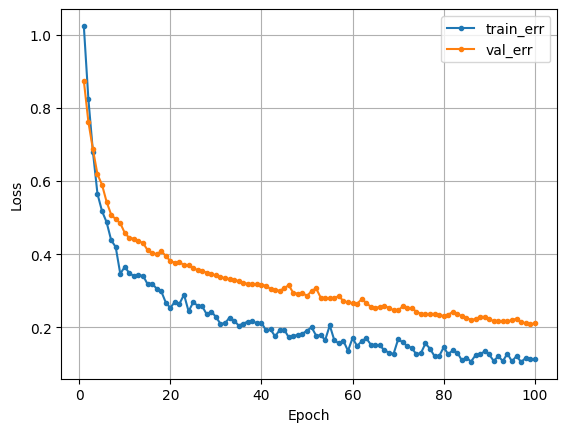

In [22]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (4) 모델 평가

* **[주의!]** 다중 분류 모델의 평가
    * ① 예측결과를
    * ② nn.Softmax함수로 변환 ==> 확률값
    * ③ 그 중 가장 큰 값의 인덱스로 변환 : np.argmax()


In [23]:
# 1. 예측결과
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

# 다중 분류의 예측 결과는 2차원 구조
pred.numpy()[:5]

array([[ 7.8109026 ,  2.6433034 , -7.477913  ],
       [-4.4958525 ,  1.5204685 , -1.0298548 ],
       [-4.511511  ,  1.1908422 , -0.9546652 ],
       [-9.031955  ,  0.67759705,  1.170497  ],
       [-2.586133  ,  1.949188  , -2.0555782 ]], dtype=float32)

In [24]:
# 2. softmax로 변환
pred = nn.functional.softmax(pred, dim=1)
pred[:5]
# [0, 1, 2]
# 1행(0,1,2)의 합이 1
# 각 열에서 가장 큰 값

tensor([[9.9433e-01, 5.6659e-03, 2.2787e-07],
        [2.2570e-03, 9.2550e-01, 7.2241e-02],
        [2.9795e-03, 8.9258e-01, 1.0444e-01],
        [2.3018e-05, 3.7920e-01, 6.2078e-01],
        [1.0422e-02, 9.7186e-01, 1.7716e-02]])

In [25]:
# 3. 가장 큰 값의 인덱스
pred = np.argmax(pred.numpy(), axis = 1)
pred[:5]

array([0, 1, 1, 2, 1])

* confusion matrix

In [26]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[13,  0,  0],
       [ 0, 18,  0],
       [ 0,  4, 10]])

* classification_report

In [27]:
le.classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [28]:
print(classification_report(y_val_ts.numpy(), pred, target_names=le.classes_))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.82      1.00      0.90        18
   virginica       1.00      0.71      0.83        14

    accuracy                           0.91        45
   macro avg       0.94      0.90      0.91        45
weighted avg       0.93      0.91      0.91        45



## **4.딥러닝2 : 은닉층 추가**

### (1) 모델 선언

In [29]:
n_feature = x.shape[1]
n_class = len(le.classes_)

# 모델 구조 설계
model = nn.Sequential(
            nn.Linear(n_feature, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, n_class),
        ).to(device)

print(model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=3, bias=True)
)


* Loss function과 Optimizer

In [30]:
loss_fn = nn.CrossEntropyLoss()       # Cross Entropy : 이 손실함수는 내부에 SoftMax 연산이 포함
optimizer = Adam(model.parameters(), lr=0.01)

### (2) 학습

In [31]:
epochs = 100
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 1.106151, val loss : 1.071072
Epoch 2, train loss : 1.065374, val loss : 1.050255
Epoch 3, train loss : 1.042710, val loss : 1.022861
Epoch 4, train loss : 0.990291, val loss : 0.987800
Epoch 5, train loss : 0.948197, val loss : 0.939505
Epoch 6, train loss : 0.867145, val loss : 0.879132
Epoch 7, train loss : 0.775401, val loss : 0.813562
Epoch 8, train loss : 0.711455, val loss : 0.749104
Epoch 9, train loss : 0.624048, val loss : 0.690256
Epoch 10, train loss : 0.556953, val loss : 0.626301
Epoch 11, train loss : 0.492582, val loss : 0.568115
Epoch 12, train loss : 0.432844, val loss : 0.506375
Epoch 13, train loss : 0.378152, val loss : 0.458056
Epoch 14, train loss : 0.338453, val loss : 0.402424
Epoch 15, train loss : 0.303700, val loss : 0.366344
Epoch 16, train loss : 0.320590, val loss : 0.335168
Epoch 17, train loss : 0.256909, val loss : 0.320493
Epoch 18, train loss : 0.240809, val loss : 0.287596
Epoch 19, train loss : 0.215015, val loss : 0.267191
Ep

* 학습 곡선

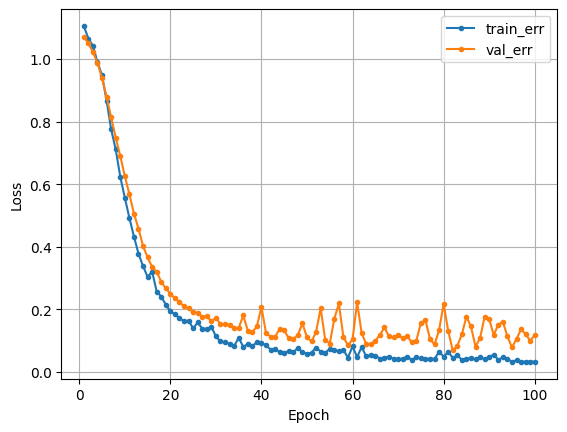

In [32]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 모델 평가

* **[주의!]** 다중 분류 모델의 평가
    * ① 예측결과를
    * ② nn.Softmax함수로 변환 ==> 확률값
    * ③ 그 중 가장 큰 값의 인덱스로 변환 : np.argmax()


In [33]:
# 1. 예측결과
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

# 다중 분류의 예측 결과는 2차원 구조
pred.numpy()[:5]

array([[ 12.12145  ,   5.6408725, -27.456335 ],
       [ -4.57681  ,   4.520874 ,  -2.9712546],
       [ -4.398946 ,   4.6164255,  -3.4163249],
       [-11.123752 ,   4.4427595,   5.8107896],
       [ -1.3002797,   4.615291 ,  -7.493167 ]], dtype=float32)

In [34]:
# 2. softmax로 변환
pred = nn.functional.softmax(pred, dim=1)
pred[:5]

tensor([[9.9847e-01, 1.5306e-03, 6.4702e-18],
        [1.1185e-04, 9.9933e-01, 5.5708e-04],
        [1.2147e-04, 9.9955e-01, 3.2451e-04],
        [3.5230e-08, 2.0294e-01, 7.9706e-01],
        [2.6899e-03, 9.9730e-01, 5.4978e-06]])

In [35]:
# 3. 가장 큰 값의 인덱스
pred = np.argmax(pred.numpy(), axis = 1)
pred[:5]

array([0, 1, 1, 2, 1])

* confusion matrix

In [36]:
confusion_matrix(y_val_ts.numpy(), pred)

array([[13,  0,  0],
       [ 0, 18,  0],
       [ 0,  3, 11]])

* classification_report

In [37]:
print(classification_report(y_val_ts.numpy(), pred, target_names=le.classes_))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.86      1.00      0.92        18
   virginica       1.00      0.79      0.88        14

    accuracy                           0.93        45
   macro avg       0.95      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45

